# EXPLORATION_10

## 프로젝트: 뉴스기사 요약해보기
새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

In [150]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('=3')

=3


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. 데이터 수집하기

In [151]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [152]:
data.sample(10)

,headlines,text
37335,Bihar CM Nitish Kumar skips International Yoga...,After Bihar Chief Minister Nitish Kumar skippe...
89887,FB to delete thousands of fake profiles ahead ...,"Facebook will be deleting ""tens of thousands"" ..."
43953,Iran backs Pakistan over Kashmir issue,Iran has backed Pakistan over the Kashmir issu...
39998,"Rao, Bhumi in Kareena, Akshay's next film with...",Rajkummar Rao and Bhumi Pednekar will star opp...
57267,PM slams Cong for choosing leader supporting '...,Prime Minister Narendra Modi on Saturday attac...
39138,China hacked sensitive US Navy undersea warfar...,China reportedly hacked the computers of a US ...
13488,Bishop granted conditional bail in Kerala nun ...,The Kerala High Court on Monday granted condit...
55445,Revolutionised the telecom sector: 2G scam acq...,After being acquitted in the 2G spectrum alloc...
56958,"Lie if you have to, don't admit you don't know...",A video of Karnataka BJP leader KS Eshwarappa ...
41987,"Donate temple flowers to widows in Mathura, Vr...",The Supreme Court on Tuesday directed temples ...


In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.



## 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

#### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [154]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [155]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [156]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


#### 텍스트 정규화와 불용어 제거

In [157]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [158]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [159]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub(r'\<[^)]*\>', '', sentence) # 괄호로 닫힌 문자열 <...> 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 headlines를 만들어 함수를 호출해 볼까요.

In [160]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great <way> to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great to start the day


**멀티프로세싱**을 사용해보자.
: 별도의 프로세스를 생성하여 병렬처리하면 CPU수에 비례하여 획기적으로 소요 시간을 줄일 수 있습니다.

In [161]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_headlines)

175.29762506484985  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

보다 쉽게 확인하기 위해 데이터들을 **데이터프레임에 재저장**할게요. 그리고 빈(empty) 값을 가진 샘플들이 있다면, **모두 Null 값을 가진 샘플로 대체**해요.



In [162]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [163]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [164]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 훈련데이터와 테스트데이터 나누기

**샘플의 최대 길이 정하기**

필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례에요.

text와 headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 볼게요.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


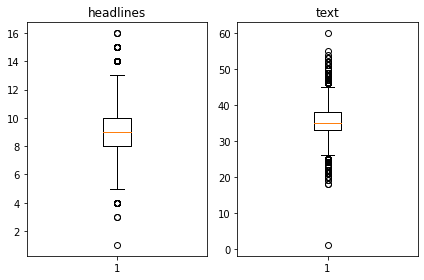

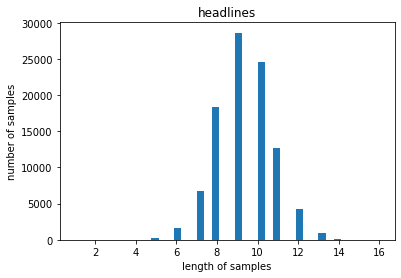

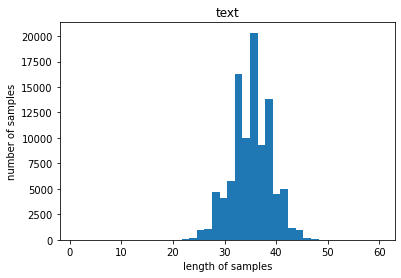

In [165]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정해볼게요.

In [166]:
text_max_len = 42
headlines_max_len = 12

각각 42과 12로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 될거예요. 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해볼게요.

In [167]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

이렇게 만든 함수를 Text와 headlines에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있겠죠

In [168]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 42 이하인 샘플의 비율: 0.9750305002033347
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


우리는 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제할게요.

In [169]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 94754


#### 시작 토큰과 종료 토큰 추가하기

In [170]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 줄게요.

In [171]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

이제 훈련 데이터와 테스트 데이터를 분리할거에요.

훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법, 또는 직접 코딩을 통해서 분리하는 방법 등 여러 가지 방법이 있을 텐데 여기서는 직접 해볼게요. 우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줄게요.

In [172]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[38743 90965 16462 ... 56358 86970 25032]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 되겠죠.

In [173]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄게요. 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해 줄게요.

In [174]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18950


이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분할게요. :표시의 위치에 주의해 주세요.

In [175]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 75804
훈련 레이블의 개수 : 75804
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


### 정수 인코딩

#### 단어 집합(vocabulary) 만들기 및 정수 인코딩
이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 해요. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요해요. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현해요. 훈련 데이터에 대해서 단어 집합을 만들어볼게요. 우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들게요.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.

In [176]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있어요. 그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 해요.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요.

In [177]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67961
등장 빈도가 6번 이하인 희귀 단어의 수: 46278
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21683
단어 집합에서 희귀 단어의 비율: 68.09493680198938
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5563583405048087


encoder_input_train에는 6만여 개의 단어가 있네요. 그 아래의 통계 정보들을 해석해볼까요?

등장 빈도가 threshold 값인 7회 미만, 즉, 6회 이하인 단어들은 단어 집합에서 무려 68% 이상을 차지하네요. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.5%밖에 되지 않아요.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 21683개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 21600으로 제한해볼게요. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.

In [178]:
src_vocab = 21600
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 19900으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요. 현재 단어 집합의 크기를 21600으로 제한했으니까 이제 21600이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않아요.

In [179]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3616, 3332, 600, 234, 144, 611, 3872, 6773, 3424, 162, 19, 1, 600, 4048, 231, 86, 1620, 9, 1098, 2935, 2301, 1805, 4584, 600, 490, 3872, 1620, 5127, 1740, 89, 867, 2455, 223, 1419, 10432, 4401, 2279, 600, 5547, 100, 388], [5602, 3509, 1747, 51, 5435, 29, 3, 2654, 1992, 574, 4942, 1335, 9252, 72, 877, 118, 890, 5176, 17055, 110, 3991, 172, 565, 5435, 29, 3, 615, 1335, 2703, 72], [5702, 6530, 20194, 17926, 312, 21, 6102, 1793, 1905, 219, 183, 1043, 83, 3992, 3226, 242, 21, 764, 1873, 200, 1388, 1365, 800, 6234, 4235, 5649, 8468, 255, 670, 5702, 1431]]


이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있어요.

Summary 데이터에 대해서도 동일한 작업을 수행할게요. 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산해요.

In [180]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 이는 tar_tokenizer.word_index에 저장되어 있어요. tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

In [181]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29550
등장 빈도가 6번 이하인 희귀 단어의 수: 20213
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9337
단어 집합에서 희귀 단어의 비율: 68.40270727580372
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.44461035450403


등장 빈도가 6회 이하인 단어들은 단어 집합에서 약 68%를 차지하고 있네요. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.4%밖에 되지 않아요. 아까 했던 것과 동일하게 이 단어들은 모두 제거할게요. 어림잡아 9300을 단어 집합의 크기로 제한할게요.

In [182]:
tar_vocab =9300
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 82, 1254, 5, 1038, 3475, 65, 7, 302, 148, 4303], [1, 4054, 1386, 3795, 1706, 1280, 4055, 89], [1, 6322, 5531, 3684, 25, 4, 1281, 169, 127], [1, 15, 149, 11, 3476, 4056, 8, 15, 636, 29, 6698, 58], [1, 261, 586, 836, 495, 496, 3477, 3, 676, 1017, 16]]
target
decoder  [[82, 1254, 5, 1038, 3475, 65, 7, 302, 148, 4303, 2], [4054, 1386, 3795, 1706, 1280, 4055, 89, 2], [6322, 5531, 3684, 25, 4, 1281, 169, 127, 2], [15, 149, 11, 3476, 4056, 8, 15, 636, 29, 6698, 58, 2], [261, 586, 836, 495, 496, 3477, 3, 676, 1017, 16, 2]]


훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 거예요.

In [183]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 75804
훈련 레이블의 개수 : 75804
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


**패딩하기**<br>
텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요. 아까 정해두었던 최대 길이로 패딩 해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [184]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='pre')

이제 학습에 필요한 데이터 전처리가 모두 끝났어요.

### 모델 설계하기

함수형 API를 이용해서 **인코더를 설계**

In [185]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했어요. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터에요. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 돼요. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니에요.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야겠죠?

**디코터 설계**

In [186]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일해요. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 해요.

**디코더의 출력층을 설계**해볼게요.

In [187]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 42, 128)      2764800     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 42, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 **다중 클래스 분류 문제**를 풀어야 해요. 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있어요.

지금까지 설계한 것은 **인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq**에요. 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있어요! 바로 **어텐션 메커니즘**이에요.

## 3. 어텐션 메커니즘 사용하기 (추상적 요약)

어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻이에요. 어텐션 함수를 설계해보는 것은 다음 기회로 미루기로 하고, 여기서는 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워볼게요.

아래의 코드를 수행하여 깃허브에 공개돼 있는 어텐션 함수를 다운로드할게요

In [188]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

이제 경로에 attention.py 파일이 생겼으니, 어텐션 메커니즘을 사용할 준비가 되었어요. **설계한 디코더의 출력층을 다음과 같이 수정**할게요.

In [189]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 42, 128)      2764800     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 42, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있어요.

### 모델 훈련하기

In [190]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
297/297 [==============================] - 206s 658ms/step - loss: 5.8881 - val_loss: 5.1702
Epoch 2/50
297/297 [==============================] - 197s 664ms/step - loss: 5.2108 - val_loss: 5.0591
Epoch 3/50
297/297 [==============================] - 197s 662ms/step - loss: 5.0719 - val_loss: 4.9347
Epoch 4/50
297/297 [==============================] - 197s 664ms/step - loss: 4.9352 - val_loss: 4.8121
Epoch 5/50
297/297 [==============================] - 197s 665ms/step - loss: 4.7915 - val_loss: 4.7076
Epoch 6/50
297/297 [==============================] - 198s 665ms/step - loss: 4.6627 - val_loss: 4.5740
Epoch 7/50
297/297 [==============================] - 197s 665ms/step - loss: 4.5067 - val_loss: 4.4518
Epoch 8/50
297/297 [==============================] - 197s 663ms/step - loss: 4.3598 - val_loss: 4.3259
Epoch 9/50
297/297 [==============================] - 196s 662ms/step - loss: 4.2066 - val_loss: 4.2031
Epoch 10/50
297/297 [==============================] - 197s 662m

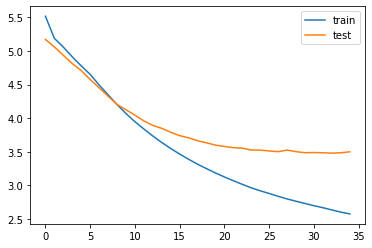

In [191]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### 인퍼런스 모델 구현하기

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [192]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다는 것, 알고 계시나요?

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [193]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계

In [194]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주세요

In [195]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 4. 실제 결과와 요약문 비교하기 (추상적 요약)

### 모델 테스트하기

테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.

In [196]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환

def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

In [197]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : claiming committee formed probe killing man eater tigress avni shiv sena chief uddhav thackeray said given supari kill tigress made members committee committee formed maharashtra government criticised killing tigress allegedly killed people 
실제 요약 : who gave to kill tigress avni are probing her death sena 
예측 요약 :  death threats for attack on fear of journo in odisha cm


원문 : new trailer sridevi th film mom released revenge thriller also stars akshaye khanna pakistani actors sajal ali adnan siddiqui nawazuddin siddiqui special appearance directed ravi ar rahman music director film scheduled release july 
실제 요약 : new trailer of sridevi th film mom released 
예측 요약 :  trailer of sridevi nawazuddin mom wish teaser of sridevi in biopic


원문 : asserting wrong give reservation muslims bjp telangana leader kishan reddy friday said reservations based religion muslim minority issue going judgment come soon baba saheb ambedkar also said reservations name religion added 
실제 요약 : there should

예측 요약 :  india beat windies to win in an odi rankings for years


원문 : saudi government demanded individual wealth princes senior officials arrested corruption probe fine return release according reports saudi princes officials including middle east wealthiest person net worth billion arrested probe 
실제 요약 : saudi seeks wealth as fine from arrested royals report 
예측 요약 :  saudi man accused of cr in saudi arabia to pay cr


원문 : gel german nurse convicted killing patients suspected killed least people police said additional cases uncovered bodies people links convict exhumed gel reportedly admitted injecting patients lethal drugs trying revive order play hero 
실제 요약 : german killer nurse suspected of more murders police 
예측 요약 :  mob who killed in murder of killing man who killed in


원문 : indusind bank tuesday reported year year increase profit june quarter bank net interest income rose year year crore quarter percentage total loans gross bad loans fell compared march quarter 
실제 요약 : 

예측 요약 :  pilot who went to fly plane for drunk man dies plane


원문 : delhi high court monday allowed gautam one five activists arrested connection bhima koregaon case freed house arrest hc granted relief saying supreme court recently given liberty approach appropriate forum within four weeks seek relief detention exceeding hours untenable court added 
실제 요약 : hc ends house arrest of activist linked to bhima koregaon case 
예측 요약 :  delhi police arrest in arrest of activists in bhima koregaon case


원문 : former pakistan prime minister nawaz sharif sunday shifted pakistan institute medical sciences islamabad health deteriorated rawalpindi prison sharif shifted showed irregular heart activity tests revealed blood senior official said suffering cardiac 
실제 요약 : ex pak pm sharif shifted to hospital as health 
예측 요약 :  nawaz sharif to be charged with pak pm nawaz sharif daughter


원문 : facebook filed patents us patent trademark office technology uses location data predict users going offline 

## 5. Summa을 이용해서 추출적 요약해보기

In [198]:
import requests
from summa.summarizer import summarize

In [199]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

#### 원문의0.45%만을 출력하도록 설정


In [200]:
for idx, (headlines, text) in enumerate(zip(data['headlines'], data['text'])):
    if idx == 50:
        break
    print("원문 :", text)
    print("실제 요약 :", headlines)
    print("예측 요약 :", summarize(text, ratio=0.45))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of bill pai

#### 단어를 17개만 선택

In [204]:
for idx, (headlines, text) in enumerate(zip(data['headlines'], data['text'])):
    if idx == 50:
        break
    print("원문 :", text)
    print("실제 요약 :", headlines)
    print("예측 요약 :", summarize(text, words=17))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of bill pai

***


# 회고

### 1. 추출적 요약과 추상적 요약 비교

### 추상적 요약

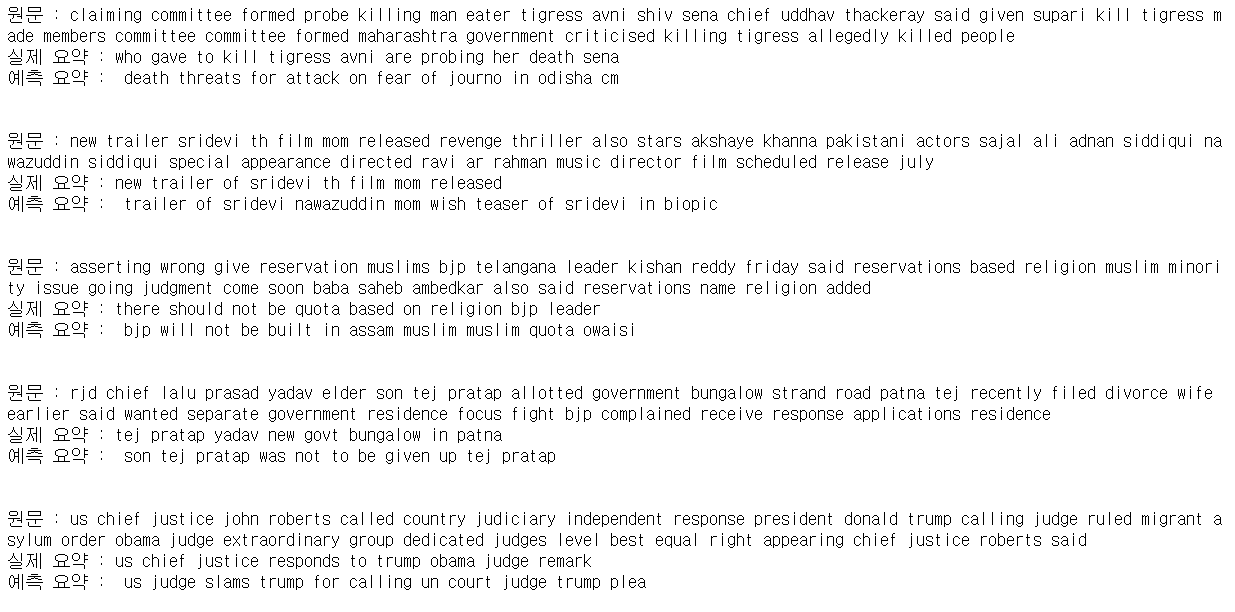

* 문법 완성도는 괜찮은 편이다. 실제 요약에 있는 단어도 예측 요약에 꽤 존재하는 걸 보아 나쁘지 않은 요약인거 같다.

### 추출적 요약 (words=17)

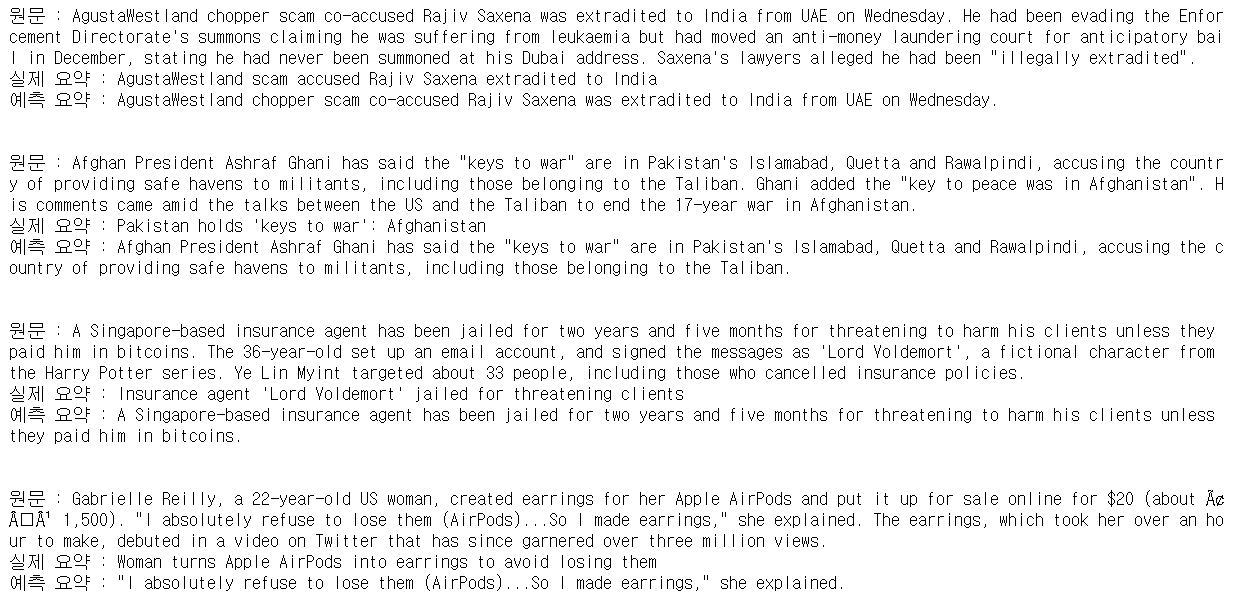

* 원문문장 그대로 가져와서 문법완성도는 좋다. 핵심단어도 잘 포함되어 있는거 같은데 확실히 원문이 길다보니 추출적 요약도 실제 요약보다는 길어지는 것 같다. 대부분 완벽한 요약은 아닌거 같다. (원문 문장중 하나를 복사+붙여넣기한 느낌)

### 2. 궁금한점

왜 중간중간 예측 요약이 되지 않고 빈칸으로 나오는지 궁금하다. 원문은 긴데 정해준 기준은 상대적으로 너무 작아서 요약을 하지 못하는걸까..? 